In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor

# TODO: I imported extra packages so make sure to import os and glob as well
# packages for importing files
import os
import glob

import sklearn.neighbors as skn

### Import and clean data (This part is the same as the data cleaning notebook; no need to go over this again)

#### For total quantity

In [2]:
df_covid = pd.read_csv("./Cleaned_Datasets/Food_Supply_Quantity_kg_Data.csv",usecols=['Country','Confirmed','Deaths','Recovered','Active','Population'])
df_covid.columns = (map(lambda x: x.lower(), df_covid.columns))
df_covid.head(3)

,country,confirmed,deaths,recovered,active,population
0,Afghanistan,0.132362,0.005628,0.107190,0.000000,38928000.0
1,Albania,2.054827,0.041614,1.185130,0.828083,2838000.0
2,Algeria,0.225211,0.006227,0.151938,0.067047,44357000.0


In [3]:
path = './Food_Supply_Quantity_Kg' # TODO: change this to the path that contains Food_Supply_Quantity_Kg on your enviroment
all_files = glob.glob(os.path.join(path, "*.csv"))

In [4]:
# function that standardize food name; all lowercase + no space + no special character
def getName(n):
    name = n.replace(' ','_')
    name = name.replace('-','')
    name = name.replace(',','')
    name = name.replace('&','')
    name = name.replace('__','_')
    return name.lower()

In [5]:
# read in the first csv in the directory so we can merge other csvs with it
col_list = ["Area", "Item", "Value"] # we only need the country and the quantity of food from the file
df_quantity = pd.read_csv(all_files[0], usecols=col_list)
name = getName(df_quantity.loc[0].at["Item"])
df_quantity = df_quantity.drop('Item', 1)
df_quantity.columns = ['country',name]

# merge all csvs in the directory into df_quantity
for i in all_files[1:len(all_files)]:
    # extract the name of the file
    tmp = pd.read_csv(i, usecols=col_list)
    name = getName(tmp.loc[0].at["Item"])
    tmp = tmp.drop('Item', 1)
    tmp.columns = ['country',name] 
    df_quantity = pd.merge(df_quantity,tmp,on ='country', how='outer')

/tmp/ipykernel_318/1764355593.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_quantity = df_quantity.drop('Item', 1)
/tmp/ipykernel_318/1764355593.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tmp = tmp.drop('Item', 1)


In [6]:
# we also need the Animal Product and Vegetal Product csvs that are in different forms, so add them to dataframe seperately
animal = pd.read_csv("./Unprocessed_Data/FAOSTAT_food_kg_animal.csv") #TODO: change this to the unprocess data directory in your enviroment
animal.columns = ['country','animal_products'] 
vegetal_prod = pd.read_csv("./Unprocessed_Data/FAOSTAT_food_kg_vegetal_prod.csv") #TODO: change this to the unprocess data directory in your enviroment
vegetal_prod.columns = ['country','vegetal_products']
df_quantity = pd.merge(df_quantity,animal,on ='country', how='outer')
df_quantity = pd.merge(df_quantity,vegetal_prod,on ='country', how='outer')

In [7]:
# sort the columns, with country at the first column, and the food columns in alphabetical order
df_quantity = df_quantity.sort_index(axis=1)
first_column = df_quantity.pop('country')
df_quantity.insert(0, 'country', first_column)

# fill na with 0
df_quantity = df_quantity.fillna(0)

In [8]:
# combine with total quantity dataframe with the covid dataframe
# TODO: if we want the df_covid to be a seperate dataframe, just delete this cell.
df_quantity = pd.merge(df_quantity,df_covid,on ='country', how='right') # join on right since the covid rates are es
#df_quantity = df_quantity.dropna()

In [9]:
df_quantity.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population
0,Afghanistan,0.01,1.41,67.42,0.0,177.30,1.50,0.25,38.23,8.59,...,9.64,0.55,3.82,48.34,289.89,0.132362,0.005628,0.107190,0.000000,38928000.0
1,Albania,42.15,3.42,473.16,0.0,145.76,14.66,5.36,171.08,47.51,...,38.74,3.82,8.22,296.86,787.33,2.054827,0.041614,1.185130,0.828083,2838000.0
2,Algeria,4.33,0.45,153.89,0.0,218.56,8.43,3.86,101.92,18.06,...,29.30,1.84,16.47,186.08,644.82,0.225211,0.006227,0.151938,0.067047,44357000.0


#### For fat

In [10]:
# function that converts g/capita/day to kg/capita/yr so that the unit is the same for df_quantity and df_fat
# TODO: someone check if this is correct
def standUnit(x):
    # g -> kg: / 1000
    # day -> year: * 365
    return x / 1000 * 365

In [11]:
# read in most csvs as a list
path = './Fat_Supply' # TODO: change this to the path that contains Food_Supply_Quantity_Kg on your enviroment
all_files = glob.glob(os.path.join(path, "*.csv"))

# read in the first csv in the directory so we can merge other csvs with it
col_list = ["Area", "Item", "Value"] # we only need the country and the quantity of food from the file
df_fat = pd.read_csv(all_files[0], usecols=col_list)
name = getName(df_fat.loc[0].at["Item"])
df_fat = df_fat.drop('Item', 1)
df_fat.columns = ['country',name]

# merge all csvs in the directory into df_fat
for i in all_files[1:len(all_files)]:
    # extract the name of the file
    tmp = pd.read_csv(i, usecols=col_list)
    name = getName(tmp.loc[0].at["Item"])
    tmp = tmp.drop('Item', 1)
    tmp.columns = ['country',name] 
    df_fat = pd.merge(df_fat,tmp,on ='country', how='outer')
    
# sort the columns, with country at the first column, and the food columns in alphabetical order
df_fat = df_fat.sort_index(axis=1)
first_column = df_fat.pop('country')
df_fat.insert(0, 'country', first_column)

# replace na with 0
df_fat = df_fat.fillna(0)

# convert g/capita/day to kg/capita/year
df_fat[df_fat.columns[1:len(df_fat.columns)]] = df_fat[df_fat.columns[1:len(df_fat.columns)]].applymap(standUnit)

df_fat = pd.merge(df_fat,df_covid,on ='country', how='right') # join on right since the covid rates are essential for further analysis, so we don't want NA in the covid rates column
#df_fat= df_fat.dropna()
df_fat.head(3)

/tmp/ipykernel_318/2802689838.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_fat = df_fat.drop('Item', 1)
/tmp/ipykernel_318/2802689838.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tmp = tmp.drop('Item', 1)


,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population
0,Afghanistan,0.0,1.39065,4.83625,0.0,1.79580,0.15330,0.0073,0.09490,1.36875,...,0.0,0.16790,3.81790,0.08030,6.34005,0.132362,0.005628,0.107190,0.000000,38928000.0
1,Albania,0.0,2.93460,27.48085,0.0,2.29585,1.41255,0.1241,0.55115,7.50805,...,0.0,0.78840,7.93875,0.55845,15.45775,2.054827,0.041614,1.185130,0.828083,2838000.0
2,Algeria,0.0,0.52195,8.38770,0.0,2.44550,0.70810,0.1168,0.33580,2.26665,...,0.0,0.50005,15.91765,0.29930,20.70280,0.225211,0.006227,0.151938,0.067047,44357000.0


#### For protein

In [12]:
# read in most csvs as a list
path = './Protein_Supply' # TODO: change this to the path that contains Food_Supply_Quantity_Kg on your enviroment
all_files = glob.glob(os.path.join(path, "*.csv"))

# read in the first csv in the directory so we can merge other csvs with it
col_list = ["Area", "Item", "Value"] # we only need the country and the quantity of food from the file
df_protein = pd.read_csv(all_files[0], usecols=col_list)
name = getName(df_protein.loc[0].at["Item"])
df_protein = df_protein.drop('Item', 1)
df_protein.columns = ['country',name]

# merge all csvs in the directory into df_protein
for i in all_files[1:len(all_files)]:
    # extract the name of the file
    tmp = pd.read_csv(i, usecols=col_list)
    name = getName(tmp.loc[0].at["Item"])
    tmp = tmp.drop('Item', 1)
    tmp.columns = ['country',name] 
    df_protein = pd.merge(df_protein,tmp,on ='country', how='outer')
    
# sort the columns, with country at the first column, and the food columns in alphabetical order
df_protein = df_protein.sort_index(axis=1)
first_column = df_protein.pop('country')
df_protein.insert(0, 'country', first_column)

# replace na with 0
df_protein = df_protein.fillna(0)

# convert g/capita/day to kg/capita/yr
df_protein[df_protein.columns[1:len(df_protein.columns)]] = df_protein[df_protein.columns[1:len(df_protein.columns)]].applymap(standUnit)

df_protein = pd.merge(df_protein,df_covid,on ='country', how='right') # join on right since the covid rates are essential for further analysis, so we don't want NA in the covid rates column
df_protein.head(3)

/tmp/ipykernel_318/1368747937.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_protein = df_protein.drop('Item', 1)
/tmp/ipykernel_318/1368747937.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tmp = tmp.drop('Item', 1)


,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,sugar_sweeteners,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population
0,Afghanistan,0.0000,0.01095,3.85075,0.0,14.20580,0.1606,0.02555,0.22995,1.23735,...,0.00000,0.05475,0.00000,0.44895,15.89210,0.132362,0.005628,0.107190,0.000000,38928000.0
1,Albania,0.1606,0.06205,24.21410,0.0,12.42095,1.5768,0.54750,1.11325,6.68315,...,0.00365,0.23360,0.00730,2.83240,19.42165,2.054827,0.041614,1.185130,0.828083,2838000.0
2,Algeria,0.0219,0.00365,9.38415,0.0,18.01640,0.8760,0.43070,0.78840,2.37980,...,0.00000,0.18615,0.01825,2.12065,24.53165,0.225211,0.006227,0.151938,0.067047,44357000.0


#### Calcualte carbs by: Quantity - proteins - fat

In [13]:
country_names = list(df_fat['country'])
covid_names = ['confirmed', 'deaths', 'recovered', 'active',
       'population']
macronutrient_source_names = ['alcoholic_beverages', 'animal_fats',
       'animal_products', 'aquatic_products_other', 'cereals_excluding_beer',
       'eggs', 'fish_seafood', 'fruits_excluding_wine', 'meat',
       'milk_excluding_butter', 'miscellaneous', 'offals', 'oilcrops',
       'pulses', 'spices', 'starchy_roots', 'stimulants', 'sugar_crops',
       'sugar_sweeteners', 'treenuts', 'vegetable_oils', 'vegetables',
       'vegetal_products']

# yearly fat intake of first three countries (alphabetical) (unit: kg/capita/yr)
fat_sum = df_fat[macronutrient_source_names].sum(axis=1)
# yearly protein intake of first three countries (alphabetical) (unit: kg/capita/yr)
protein_sum = df_protein[macronutrient_source_names].sum(axis=1)
#yearly carbohydrate intake of first three countries (alphabetical) (unit: kg/capita/yr)
#computed by total quantity-protein-fat
carb_sum=df_quantity.sum(axis=1)-protein_sum-fat_sum
# create macronutrients summary dataframe
df_macro = pd.DataFrame({'country': country_names,
                          'fat_sum': fat_sum,
                          'protein_sum': protein_sum,
                          'carb_sum':carb_sum})
df_macro = pd.merge(df_macro,df_covid,on ='country', how='right')

/tmp/ipykernel_318/549992191.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  carb_sum=df_quantity.sum(axis=1)-protein_sum-fat_sum


In [14]:
df_macro.describe()

,fat_sum,protein_sum,carb_sum,confirmed,deaths,recovered,active,population
count,170.000000,170.000000,1.700000e+02,164.000000,164.000000,164.000000,163.000000,1.700000e+02
mean,62.090193,57.051561,4.452486e+07,1.572195,0.030303,1.091748,0.452030,4.452364e+07
std,28.394605,17.968633,1.564182e+08,1.847807,0.038493,1.436841,1.022697,1.564182e+08
min,0.000000,0.000000,5.492777e+04,0.000312,0.000000,0.000000,0.000000,5.400000e+04
25%,41.528787,46.318500,2.817775e+06,0.108875,0.001592,0.068394,0.007899,2.816250e+06
50%,58.295975,58.440150,1.018319e+07,0.749942,0.009075,0.386444,0.063306,1.018150e+07
75%,81.113950,69.292513,3.271723e+07,2.662717,0.045104,1.738031,0.358045,3.271625e+07
max,122.059650,102.933650,1.402387e+09,7.811736,0.170048,6.483861,5.996430,1.402385e+09


### Multiple linear regression: confirmed ~ fat_sum + protein_sum + carb_sum

In [15]:
### drop NA before running models
df_covid = df_covid.dropna()
df_fat = df_fat.dropna()
df_protein = df_protein.dropna()
df_quantity = df_quantity.dropna()
df_carbs = carb_sum.dropna()
df_macro = df_macro.dropna()

In [16]:
## -log transform the confirmed rate; 
## since in the original df, the confirmend is already in rates (ex: 0.132 means 0.132% instead of 13.2%), divide by 100 before log transform 
df_macro['logConfirmed'] = -np.log(df_macro['confirmed'] / 100)
df_macro.head(3)

,country,fat_sum,protein_sum,carb_sum,confirmed,deaths,recovered,active,population,logConfirmed
0,Afghanistan,22.34895,39.48570,3.892865e+07,0.132362,0.005628,0.107190,0.000000,38928000.0,6.627383
1,Albania,85.87720,87.26785,2.840352e+06,2.054827,0.041614,1.185130,0.828083,2838000.0,3.884978
2,Algeria,58.17735,67.82430,4.435847e+07,0.225211,0.006227,0.151938,0.067047,44357000.0,6.095886


In [17]:
## since we have multiple regression variables, we need to check for multicollinearity using VIF

# the independent variables set
X = df_macro[['fat_sum','protein_sum','carb_sum']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

       feature        VIF
0      fat_sum  16.991824
1  protein_sum  17.259546
2     carb_sum   1.086493


We can see fat and protein have too high of VIF (VIF > 5 means multicollinearity), so we can't really use linear regression models.

### Multiple linear regression: confirmed ~ quantity of the 23 components

In [18]:
df_quantity['logConfirmed'] = -np.log(df_quantity['confirmed'] / 100)
df_quantity.head(3)

,country,alcoholic_beverages,animal_fats,animal_products,aquatic_products_other,cereals_excluding_beer,eggs,fish_seafood,fruits_excluding_wine,meat,...,treenuts,vegetable_oils,vegetables,vegetal_products,confirmed,deaths,recovered,active,population,logConfirmed
0,Afghanistan,0.01,1.41,67.42,0.0,177.30,1.50,0.25,38.23,8.59,...,0.55,3.82,48.34,289.89,0.132362,0.005628,0.107190,0.000000,38928000.0,6.627383
1,Albania,42.15,3.42,473.16,0.0,145.76,14.66,5.36,171.08,47.51,...,3.82,8.22,296.86,787.33,2.054827,0.041614,1.185130,0.828083,2838000.0,3.884978
2,Algeria,4.33,0.45,153.89,0.0,218.56,8.43,3.86,101.92,18.06,...,1.84,16.47,186.08,644.82,0.225211,0.006227,0.151938,0.067047,44357000.0,6.095886


In [19]:
# the independent variables set
X = df_quantity[df_quantity.columns[1:24]]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                   feature           VIF
0      alcoholic_beverages  3.171038e+05
1              animal_fats  3.369007e+05
2          animal_products  4.198737e+08
3   aquatic_products_other  3.690743e+02
4   cereals_excluding_beer  2.079180e+06
5                     eggs  6.102008e+05
6             fish_seafood  4.545778e+06
7    fruits_excluding_wine  7.893919e+05
8                     meat  2.525826e+07
9    milk_excluding_butter  1.761414e+08
10           miscellaneous  8.864772e+03
11                  offals  8.096053e+04
12                oilcrops  5.300733e+04
13                  pulses  7.369083e+03
14                  spices  3.442267e+02
15           starchy_roots  8.651933e+05
16              stimulants  1.718011e+03
17             sugar_crops  2.634779e+03
18        sugar_sweeteners  1.880414e+05
19                treenuts  6.188031e+02
20          vegetable_oils  1.388086e+04
21              vegetables  1.132907e+06
22        vegetal_products  2.432908e+07


Similarly, we can't use linear regression due to high multicollinearity.

### Thus a better way is to use KNN regressor to build our model.

#### KNN model for macros
  

In [20]:
def flat(l):
    return [item for sublist in l for item in sublist]

In [21]:
X = df_macro[['fat_sum','protein_sum','carb_sum']].values
X = X.astype(float)
y = df_macro[['logConfirmed']].values

In [22]:
shuffle = np.random.permutation(len(y))
num = int(0.8*len(shuffle))
train, test = shuffle[:num],shuffle[num:]

In [23]:
X_train = X[train,:]
y_train = y[train,:]
X_test = X[test,:]
y_test = y[test,:]

In [72]:
# fit
neigh = skn.KNeighborsRegressor(n_neighbors=7)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [73]:
y_pred_train = flat(neigh.predict(X_train).tolist())
y_pred_test = flat(neigh.predict(X_test).tolist())

In [74]:
# conbine the actual result and predicted result into dataframes
df_train = pd.DataFrame({'log_actual_confirmed': flat(y_train), 'log_pred_confirmed': y_pred_train})
df_test = pd.DataFrame({'log_actual_confirmed': flat(y_test), 'log_pred_confirmed': y_pred_test})

For the train set, he correlation coefficent between the predicted rate and the acutal rate is: 0.4706190345476651 with p-val of 1.603071200742726e-08


<AxesSubplot:xlabel='log_actual_confirmed', ylabel='log_pred_confirmed'>

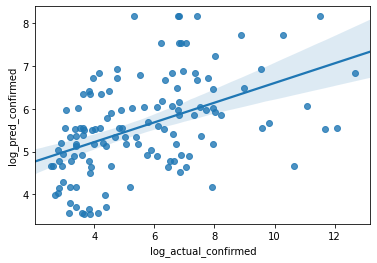

In [75]:
# show the result
corr, p = stats.pearsonr(df_train['log_actual_confirmed'], df_train['log_pred_confirmed'])
print("For the train set, he correlation coefficent between the predicted rate and the acutal rate is:", corr, "with p-val of", p)
sns.regplot(x='log_actual_confirmed', y='log_pred_confirmed', data=df_train,truncate=False)

For the test set, he correlation coefficent between the predicted rate and the acutal rate is: 0.305376685860712 with p-val of 0.0839581033011516


<AxesSubplot:xlabel='log_actual_confirmed', ylabel='log_pred_confirmed'>

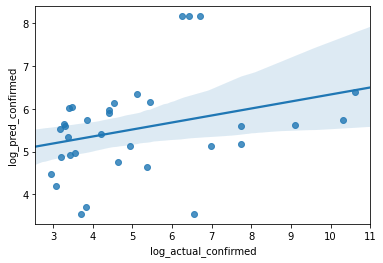

In [76]:
corr, p = stats.pearsonr(df_test['log_actual_confirmed'], df_test['log_pred_confirmed'])
print("For the test set, he correlation coefficent between the predicted rate and the acutal rate is:", corr, "with p-val of", p)
sns.regplot(x='log_actual_confirmed', y='log_pred_confirmed', data=df_test,truncate=False)